# Facebook messenger statistics
Paste the path to a directory of a chat you'd like to analyze. It should contain 1 or more json files with names like 'message1.json'. The path should be enclosed with single or double quotes, and there should be an 'r' in front of the quotes, like this:<br>
PATH = _r'C:\mypath\mychat'<br>_
When that's ready you can click on Cell in the menu above and select 'Run All'

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import stats_pandas as stats
import pandas as pd
import seaborn as sns
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.express as px

init_notebook_mode(connected=True)
 
PATH = r'D:\facebook html i json\sluzewiaki'

chat = stats.load_from_path(PATH)

## General chat statistics

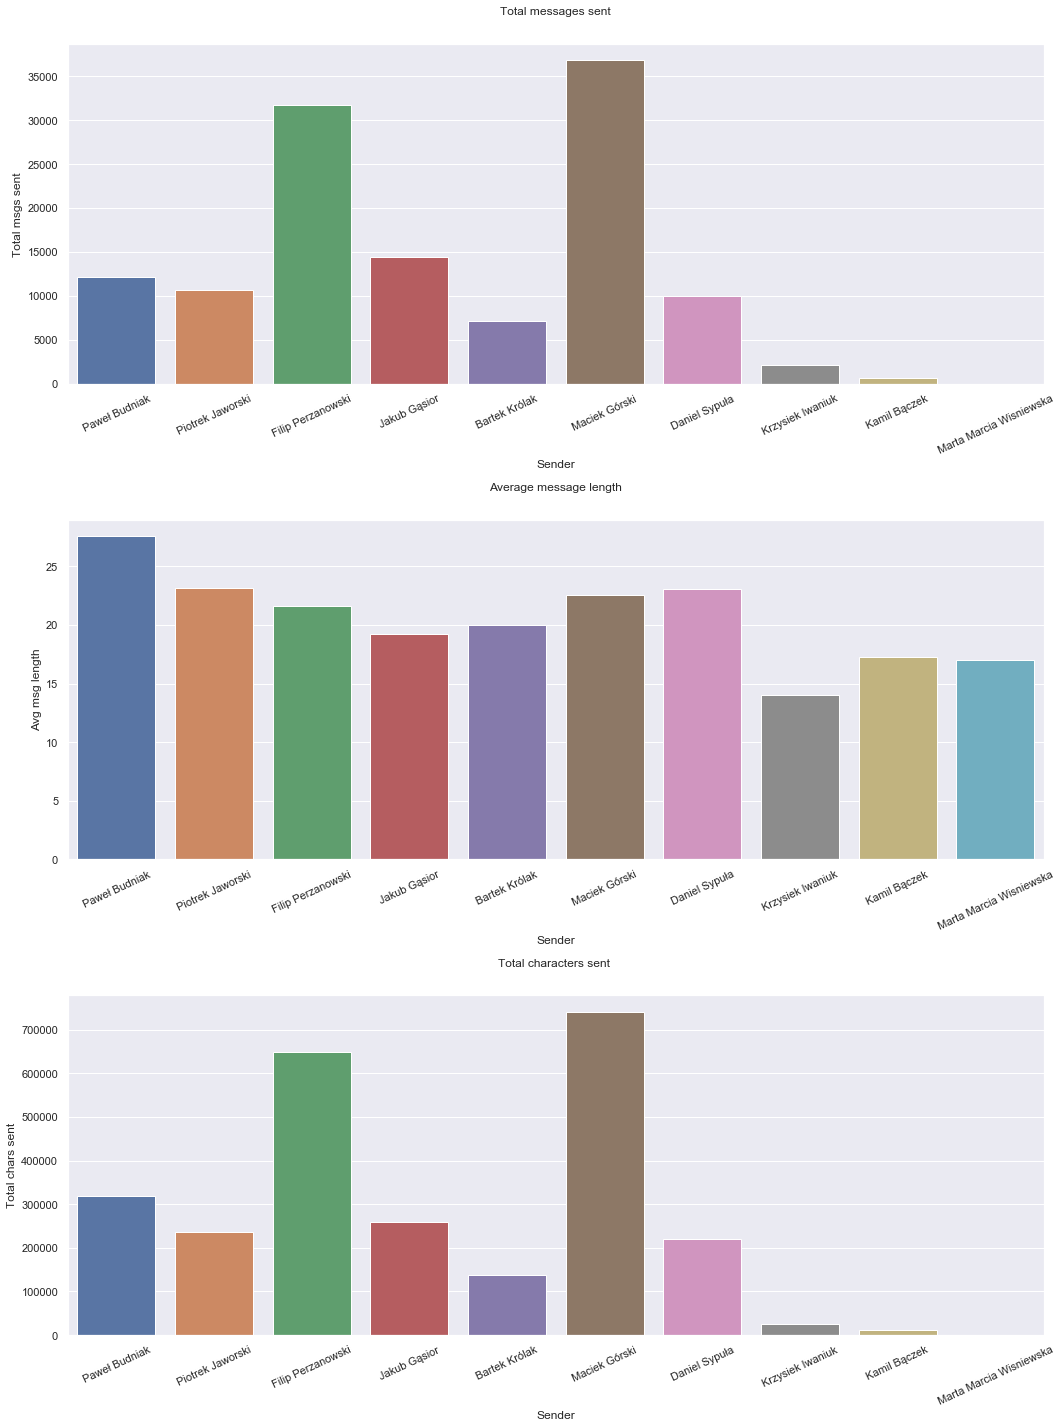

In [2]:
msg_stats = stats.get_msg_stats(chat)
df = pd.DataFrame(((k,*v) for k,v in msg_stats.items()))
df.columns = ['Sender', 'Total msgs sent', 'Avg msg length', 'Total chars sent']

sns.set()
fig, axs = plt.subplots(3,1, figsize = (15,20))
sns.barplot(y = 'Total msgs sent', x = 'Sender', data =df, ax = axs[0])
axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation = 25)
axs[0].set_title('Total messages sent\n\n')
sns.barplot(y = 'Avg msg length', x = 'Sender', data = df, ax = axs[1])
axs[1].set_title('Average message length\n\n')                                                                    
axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation = 25)
sns.barplot(y = 'Total chars sent', x = 'Sender', data = df, ax = axs[2])
axs[2].set_title('Total characters sent \n\n')                                                                    
axs[2].set_xticklabels(axs[1].get_xticklabels(), rotation = 25)
fig.tight_layout()
plt.show()

## Top 20 words most frequently used by each chat participant
You can change the minimal word lengths below

In [3]:
excluded = ['debesciak', 'pierdziano', 'czlowiek', 'wielkiego', 'szacunku', 'glawiator', 'tajtisów', 'klawy', 'ziom3q']


#### change min_word_length here
min_word_length = 6 


word_counts = stats.get_word_counts(chat, filter_participants_names = True, min_len = min_word_length, exclude_words = excluded)

In [4]:
plt_titles = [f'{sender} - min. word length = {min_word_length}' for sender in word_counts]
fig = make_subplots(
    rows=len(word_counts),
    cols=1,
    subplot_titles=plt_titles
)
for i,sender in enumerate(word_counts):
    df = pd.DataFrame(word_counts[sender].items())[0:20]
    df.columns = ['word', 'count']
    f = px.bar(df, y = 'count', x = 'word', color = 'count')
    fig.add_trace(f.data[0], row = i + 1, col = 1)
fig.update_layout(height=3500, width=900)
fig.show()

## How often has _word1_ been used?
Set _word1_ below

In [5]:
word_counts = stats.get_word_counts(chat, False, None, 1) #get unfiltered word_counts

In [33]:
word1 = 'dlaczego' ## set word1 here



w1_coeffs = stats.word_usage_coefficients(word1, word_counts, msg_stats)
w1_coeffs = {k:v * 100 for k,v in sorted(w1_coeffs.items(), key = lambda item: item[1], reverse = True)}
w1_df = pd.DataFrame(w1_coeffs.items(), columns = ['Sender', f'{word1} per 100 msgs'])
fig = px.bar(w1_df, y = f'{word1} per 100 msgs', x = 'Sender')
fig.show()

## How often has every (polish) swear word been used?

In [26]:
pcoeffs = stats.get_profanity_coefficients(word_counts, msg_stats, ignore_kurwas = False)

pcoeffs = {k:v * 100 for k,v  in sorted(pcoeffs.items(), key = lambda item: item[1], reverse = True)}
df = pd.DataFrame(pcoeffs.items(), columns = ['Sender', 'Profanity per 100 msgs'])
fig = px.bar(df, y = 'Profanity per 100 msgs', x = 'Sender')
fig.show()
df

,Sender,Profanity per 100 msgs
0,Maciek Górski,8.560565
1,Kamil Bączek,8.510638
2,Paweł Budniak,8.144685
3,Bartek Królak,8.043083
4,Filip Perzanowski,6.577410
5,Daniel Sypuła,6.489234
6,Jakub Gąsior,5.952712
7,Piotrek Jaworski,4.456378
8,Krzysiek Iwaniuk,3.270142
9,Marta Marcia Wisniewska,0.000000


## Correlation of _word1_ usage with (polish) swear word usage

In [34]:
df = pd.DataFrame(pcoeffs.items(), columns = ['Sender', 'Profanity per 100 msgs'])
df = df.merge(w1_df, how = 'inner')
cor = df.corr().iloc[0,1]
fig = px.scatter(df,y = 'Profanity per 100 msgs', x = f'{word1} per 100 msgs', trendline="ols", trendline_color_override = 'pink')
fig.show()
print('The correlation is', cor)

The correlation is 0.420031035889963


## Correlation of _word1_ (set above) usage with _word2_ (set below) usage

In [29]:

word2 = 'czemu' # set word2 here




if word1 == word2:
    print('word 2 has to be different from word1')
w2_coeffs = stats.word_usage_coefficients(word2, word_counts, msg_stats)
w2_coeffs = {k:v * 100 for k,v in w2_coeffs.items()}
w2_df = pd.DataFrame(w2_coeffs.items(), columns = ['Sender', f'{word2} per 100 msgs'])

nat_join = w2_df.merge(w1_df, how = 'inner')
cor = nat_join.corr().iloc[0,1]
fig = px.scatter(nat_join,y = f'{word2} per 100 msgs', x = f'{word1} per 100 msgs', trendline="ols", trendline_color_override = 'pink')
fig.show()
print('The correlation is', cor)

The correlation is -0.4432416286048014


## Types of messages sent

In [11]:
import math

msg_types = stats.get_msg_types(chat, include_txt = False)

fig = make_subplots(
    rows=math.ceil(len(msg_types)/2),
    cols=2,
    subplot_titles=tuple(msg_types.keys()),
    specs =[[{'type':'domain'}]*2]*(math.ceil(len(msg_types)/2))
)

for i,sender in enumerate(msg_types):
    mydf = pd.DataFrame.from_dict(msg_types[sender], orient = 'index', columns = ['count'])
    f = px.pie(mydf, values = 'count', names = mydf.index)
    fig.add_trace(f.data[0], row = math.ceil((i+1)/2), col = (i)%2+1)
fig.update_layout(height=2500, width=900)
fig.show()

In [12]:
pd.DataFrame(msg_types)

,Paweł Budniak,Piotrek Jaworski,Filip Perzanowski,Jakub Gąsior,Bartek Królak,Maciek Górski,Daniel Sypuła,Krzysiek Iwaniuk,Kamil Bączek,Marta Marcia Wisniewska
photos,578,307,1231,652.0,236.0,3254,422.0,165,23.0,1.0
videos,4,11,170,38.0,14.0,570,48.0,21,NaN,1.0
audio_files,1,1,37,7.0,NaN,135,5.0,2,NaN,NaN
gifs,5,1,63,53.0,NaN,107,NaN,4,NaN,NaN
files,2,4,1,NaN,NaN,12,NaN,1,NaN,NaN
sticker,12,36,110,65.0,6.0,101,3.0,75,16.0,NaN
share,86,29,99,94.0,13.0,315,35.0,32,5.0,NaN


## Messages over time

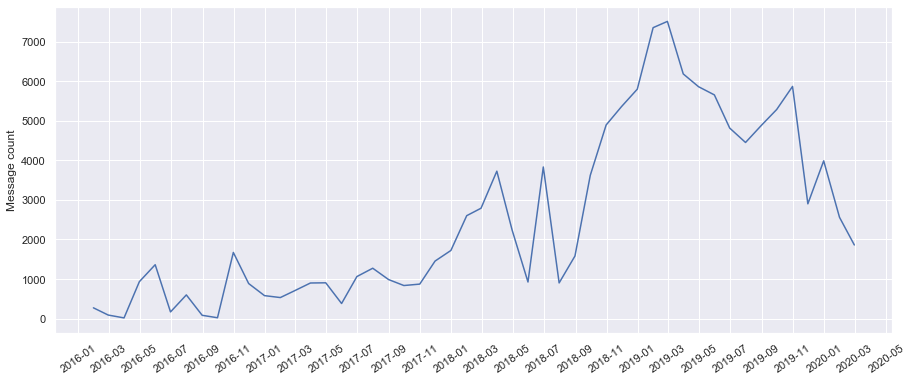

In [35]:
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
import warnings 

with warnings.catch_warnings():
    warnings.simplefilter("ignore") 
    
    sns.set(rc={'figure.figsize':(15,6)})
    dates = groupby_date(chat, 'M')
    ax = sns.lineplot(data=dates)
    plt.xticks(rotation=35)
    date_form = DateFormatter("%Y-%m")
    ax.set(ylabel='Message count')
    ax.xaxis.set_major_formatter(date_form)
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
plt.show()

## Messages by time intervals

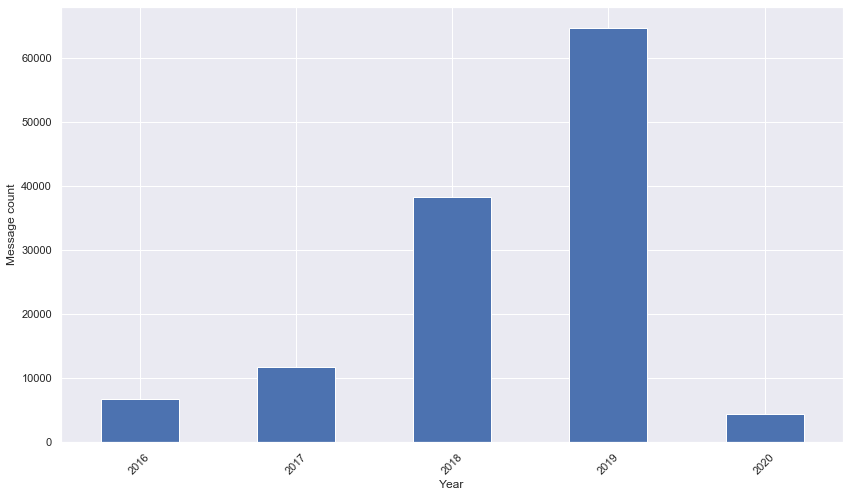

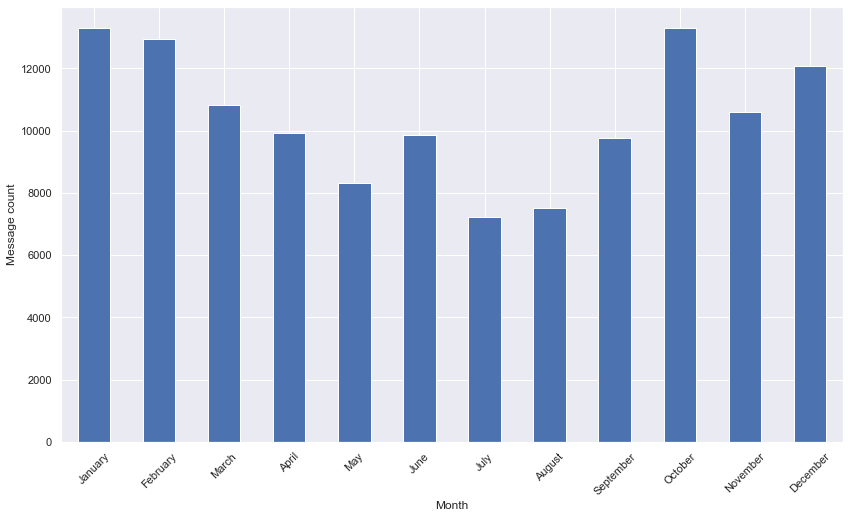

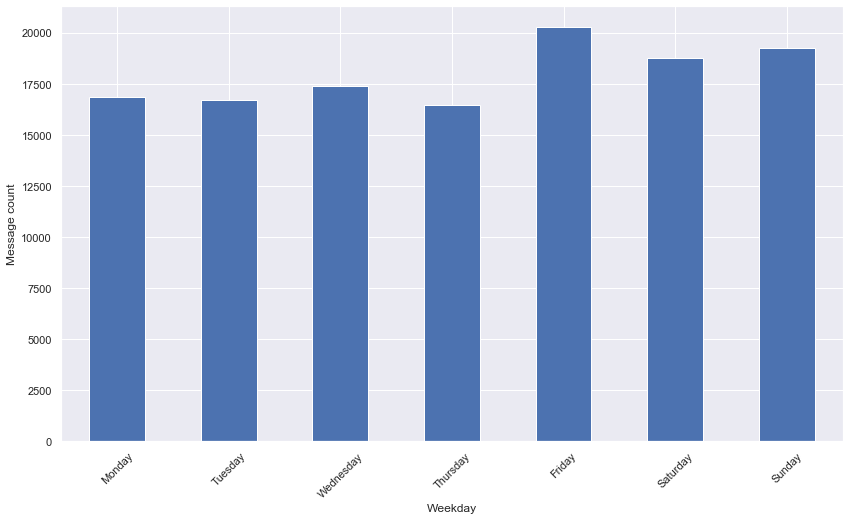

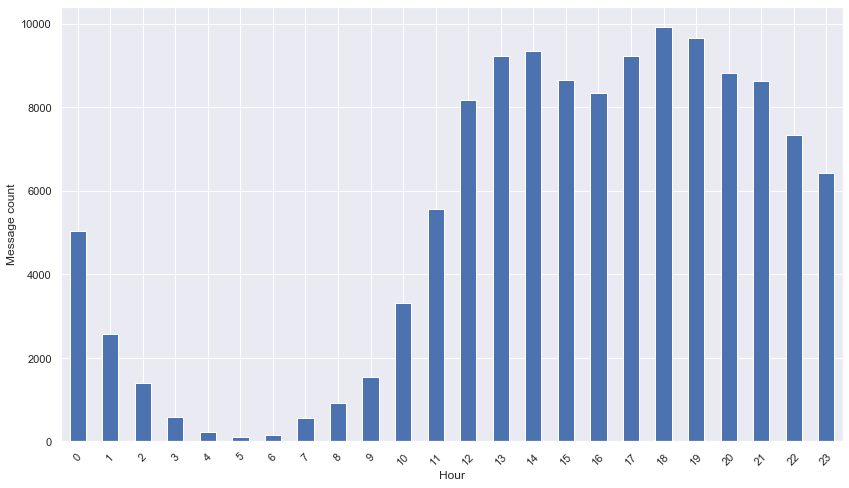

In [14]:
intervals = ['Y', 'M', 'W', 'H']
fullnames = {'Y': 'Year', 'M': 'Month', 'W': 'Weekday', 'H': 'Hour'}
for i, interval in enumerate (intervals):
    plt.figure(i)
    counts_by_time = stats.groupby_time(chat, interval, interval_names = True)
    ax = counts_by_time.plot(kind='bar', rot = 45, figsize = (14,8))
    ax.set_ylabel('Message count')
    ax.set_xlabel(fullnames[interval])
plt.show()

## Total reactions used in the chat

In [15]:
total_reacts = pd.Series(stats.total_reacts(chat)).sort_values(ascending = False)
fig = make_subplots(
    rows=1,
    cols=2,
    subplot_titles=('Total reactions flat', 'Total reactions percentages'),
    #specs =[[, {'type':'domain'}]]
    specs = [[{'type': 'bar'}, {'type':'domain'}]]
)
f1 = px.bar(x=total_reacts.index, y=total_reacts)
f2 = px.pie(values = total_reacts, names = total_reacts.index)
f2.update_traces(textposition='inside', textinfo='percent+label')
fig.add_trace(f1.data[0], row = 1, col = 1) 
fig.add_trace(f2.data[0], row = 1, col = 2) 
fig.show()

## Reactions used by participant
Seaborn/matplotlib can't display emojis on labels, so for pretty emoji graphs try the plotly notebook version

In [16]:
used, received = stats.reaction_stats(chat)
used

,👍,😍,😮,😆,😠,👎,😢,❤,total,most_used
Paweł Budniak,149.0,39.0,72.0,41.0,28.0,52.0,36.0,6.0,423.0,👍
Piotrek Jaworski,126.0,126.0,49.0,56.0,15.0,44.0,72.0,0.0,488.0,👍
Filip Perzanowski,153.0,92.0,53.0,78.0,32.0,67.0,53.0,0.0,528.0,👍
Jakub Gąsior,231.0,114.0,178.0,42.0,30.0,74.0,88.0,0.0,757.0,👍
Bartek Królak,69.0,58.0,48.0,103.0,14.0,10.0,19.0,0.0,321.0,😆
Maciek Górski,143.0,132.0,20.0,17.0,22.0,87.0,26.0,0.0,447.0,👍
Daniel Sypuła,79.0,71.0,89.0,137.0,13.0,9.0,56.0,6.0,460.0,😆
Krzysiek Iwaniuk,26.0,23.0,4.0,20.0,1.0,2.0,8.0,0.0,84.0,👍
Kamil Bączek,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,👍
Marta Marcia Wisniewska,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,👍


## Reactions received by participant

In [17]:
received

,👍,😮,😍,😠,👎,😆,😢,❤,total,most_received
Paweł Budniak,160.0,59.0,63.0,26.0,59.0,111.0,28.0,2.0,508.0,👍
Piotrek Jaworski,111.0,49.0,43.0,13.0,48.0,30.0,22.0,1.0,317.0,👍
Filip Perzanowski,188.0,135.0,125.0,30.0,69.0,63.0,98.0,0.0,708.0,👍
Jakub Gąsior,183.0,53.0,145.0,26.0,39.0,84.0,64.0,4.0,598.0,👍
Bartek Królak,34.0,37.0,37.0,3.0,18.0,21.0,12.0,0.0,162.0,😮
Maciek Górski,216.0,123.0,179.0,45.0,66.0,155.0,99.0,4.0,887.0,👍
Daniel Sypuła,78.0,47.0,55.0,10.0,43.0,26.0,33.0,1.0,293.0,👍
Krzysiek Iwaniuk,6.0,10.0,8.0,2.0,3.0,4.0,2.0,0.0,35.0,😮
Kamil Bączek,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,👍
Marta Marcia Wisniewska,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,👍


## Ratio of each reaction received to total messages sent by each person

In [18]:
percents = stats.react_percents(received, msg_stats)
percents

,👍,😮,😍,😠,👎,😆,😢,❤,total,most_received
Paweł Budniak,1.31%,0.48%,0.52%,0.21%,0.48%,0.91%,0.23%,0.02%,4.17%,👍
Piotrek Jaworski,1.05%,0.46%,0.41%,0.12%,0.45%,0.28%,0.21%,0.01%,2.99%,👍
Filip Perzanowski,0.59%,0.43%,0.39%,0.09%,0.22%,0.20%,0.31%,0.00%,2.24%,👍
Jakub Gąsior,1.27%,0.37%,1.01%,0.18%,0.27%,0.58%,0.45%,0.03%,4.16%,👍
Bartek Królak,0.48%,0.52%,0.52%,0.04%,0.25%,0.29%,0.17%,0.00%,2.27%,😮
Maciek Górski,0.59%,0.33%,0.49%,0.12%,0.18%,0.42%,0.27%,0.01%,2.41%,👍
Daniel Sypuła,0.78%,0.47%,0.55%,0.10%,0.43%,0.26%,0.33%,0.01%,2.92%,👍
Krzysiek Iwaniuk,0.28%,0.47%,0.38%,0.09%,0.14%,0.19%,0.09%,0.00%,1.66%,😮
Kamil Bączek,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,👍
Marta Marcia Wisniewska,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,👍


## People who receive the most reactions

In [19]:
titles = [ ('funniest', '😆'), ('most hated','👎'), ('most infuriating', '😠'),
           ('most beloved', '😍'), ('most shocking', '😮'), ('saddest', '😢')]

for title, emoji in titles:
    stats.most_reactions(received, title, emoji, percent = False)

The funniest person is Maciek Górski: 155.0 of his messages received '😆', 2nd place: Paweł Budniak (111.0)

The most hated person is Filip Perzanowski: 69.0 of his messages received '👎', 2nd place: Maciek Górski (66.0)

The most infuriating person is Maciek Górski: 45.0 of his messages received '😠', 2nd place: Filip Perzanowski (30.0)

The most beloved person is Maciek Górski: 179.0 of his messages received '😍', 2nd place: Jakub Gąsior (145.0)

The most shocking person is Filip Perzanowski: 135.0 of his messages received '😮', 2nd place: Maciek Górski (123.0)

The saddest person is Maciek Górski: 99.0 of his messages received '😢', 2nd place: Filip Perzanowski (98.0)



## People who receive the most reactions relative to the number of messages they send

In [20]:
for title, emoji in titles:
    stats.most_reactions(percents, title, emoji, percent = True)

The funniest person is Paweł Budniak: 0.91% of his messages received '😆', 2nd place: Jakub Gąsior (0.58%)

The most hated person is Paweł Budniak: 0.48% of his messages received '👎', 2nd place: Piotrek Jaworski (0.45%)

The most infuriating person is Paweł Budniak: 0.21% of his messages received '😠', 2nd place: Jakub Gąsior (0.18%)

The most beloved person is Jakub Gąsior: 1.01% of his messages received '😍', 2nd place: Daniel Sypuła (0.55%)

The most shocking person is Bartek Królak: 0.52% of his messages received '😮', 2nd place: Paweł Budniak (0.48%)

The saddest person is Jakub Gąsior: 0.45% of his messages received '😢', 2nd place: Daniel Sypuła (0.33%)

